<a href="https://colab.research.google.com/github/leninvarma11/Homework-4-Lenin-Varma-Nallapu-700076011/blob/main/homework_4_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded text with 8344 characters
Vocab size: 15
Epoch 1/10 - Train loss: 0.8193, Val loss: 0.2544, Val ppl: 1.29
Epoch 2/10 - Train loss: 0.2560, Val loss: 0.2375, Val ppl: 1.27
Epoch 3/10 - Train loss: 0.2469, Val loss: 0.2334, Val ppl: 1.26
Epoch 4/10 - Train loss: 0.2440, Val loss: 0.2334, Val ppl: 1.26
Epoch 5/10 - Train loss: 0.2425, Val loss: 0.2328, Val ppl: 1.26
Epoch 6/10 - Train loss: 0.2415, Val loss: 0.2318, Val ppl: 1.26
Epoch 7/10 - Train loss: 0.2408, Val loss: 0.2322, Val ppl: 1.26
Epoch 8/10 - Train loss: 0.2403, Val loss: 0.2343, Val ppl: 1.26
Epoch 9/10 - Train loss: 0.2401, Val loss: 0.2346, Val ppl: 1.26
Epoch 10/10 - Train loss: 0.2398, Val loss: 0.2330, Val ppl: 1.26


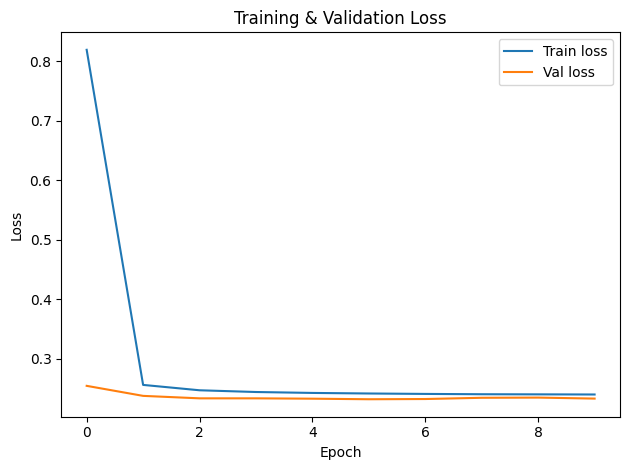


Sample generation (temperature = 0.7)
help
help me learn rnn
helium
help me learn rnn
hello
hello
hello
hello world
hello
hello
hello world
help
help me learn rnn
help me learn rnn
help me learn rnn
hello
hello world
help
hello world
hello world
helium
hello
hello
hello world
helium
hello
hello
help me learn rnn
help
help
help
help
hello
h


Sample generation (temperature = 1.0)
hello world
helium
help me learn rnn
help me learn rnn
helium
help me learn rnn
hello
helium
hello
help me learn rnn
hero
hello
help
hero
helium
help
hello
heap
hero
help me learn rnn
help
helium
hero
help
helium
help
hello world
help me learn rnn
hello world
hello
help
hello world
heap
helium
hero
her


Sample generation (temperature = 1.2)
help
hero
help me learn rnn
heap
help
hello
hero
hero
hero
helium
hello
heap
hero
hello world
help
helium
help
hello world
hello
hello world
hello world
helium
heap
hello world
hello world
helium
hero
help
help me learn rnn
help me learn rnn
hero
help
hello world
hello wor

In [ ]:
## programming questions

#1 Question

import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --------------------
# Config
# --------------------
USE_TOY_CORPUS = True      # Set to False to use an external text file
TEXT_PATH = "data.txt"     # Path for your 50–200 KB text file

SEQ_LEN = 100              # sequence length (50–100 as per question)
BATCH_SIZE = 64
EMBED_DIM = 64             # embedding size
HIDDEN_SIZE = 128          # 64–256 is fine
NUM_LAYERS = 1
RNN_TYPE = "gru"           # "rnn", "gru", or "lstm"
NUM_EPOCHS = 10            # 5–20 epochs
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


# --------------------
# Data loading
# --------------------
def load_text():
    if USE_TOY_CORPUS:
        # Toy corpus: repeat some short phrases to get a non-trivial text
        phrases = [
            "hello\n",
            "help\n",
            "helium\n",
            "hero\n",
            "heap\n",
            "hello world\n",
            "help me learn rnn\n",
        ]
        text = "".join(random.choice(phrases) for _ in range(1000))
        return text
    else:
        with open(TEXT_PATH, "r", encoding="utf-8") as f:
            return f.read()


text = load_text()
print(f"Loaded text with {len(text)} characters")

# Build vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocab size: {vocab_size}")

char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

# Encode entire text as a tensor of indices
data = torch.tensor([char2idx[ch] for ch in text], dtype=torch.long)


# --------------------
# Dataset & DataLoader
# --------------------
class CharDataset(Dataset):
    def __init__(self, data_tensor, seq_len):
        self.data = data_tensor
        self.seq_len = seq_len

    def __len__(self):
        # We create (input, target) pairs where target is input shifted by 1
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_len]
        y = self.data[idx + 1 : idx + 1 + self.seq_len]  # next char for each position
        return x, y


# Simple temporal (contiguous) train/val split on the sequence
split_idx = int(0.9 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]

train_dataset = CharDataset(train_data, SEQ_LEN)
val_dataset = CharDataset(val_data, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --------------------
# Model
# --------------------
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, num_layers=1, rnn_type="gru"):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type.lower()

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        if self.rnn_type == "rnn":
            self.rnn = nn.RNN(embed_dim, hidden_size, num_layers, batch_first=True)
        elif self.rnn_type == "gru":
            self.rnn = nn.GRU(embed_dim, hidden_size, num_layers, batch_first=True)
        elif self.rnn_type == "lstm":
            self.rnn = nn.LSTM(embed_dim, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'rnn', 'gru', or 'lstm'")

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        """
        x: (batch, seq_len)
        hidden: initial hidden state
        returns:
            logits: (batch, seq_len, vocab_size)
            hidden: final hidden state
        """
        emb = self.embedding(x)  # (batch, seq_len, embed_dim)
        out, hidden = self.rnn(emb, hidden)  # out: (batch, seq_len, hidden_size)
        logits = self.fc(out)  # (batch, seq_len, vocab_size)
        return logits, hidden

    def init_hidden(self, batch_size, device):
        if self.rnn_type == "lstm":
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
            return (h0, c0)
        else:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
            return h0


model = CharRNN(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    rnn_type=RNN_TYPE,
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


# --------------------
# Training & Evaluation
# --------------------
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            logits, _ = model(x)
            # Reshape for CE: (batch * seq_len, vocab_size)
            loss = criterion(
                logits.view(-1, vocab_size),
                y.view(-1)
            )

            batch_tokens = y.numel()
            total_loss += loss.item() * batch_tokens
            total_tokens += batch_tokens

    return total_loss / total_tokens


train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    total_tokens = 0

    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()

        # Teacher forcing: we feed the whole ground-truth sequence x
        logits, _ = model(x)

        loss = criterion(
            logits.view(-1, vocab_size),
            y.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # stabilizes training
        optimizer.step()

        batch_tokens = y.numel()
        total_loss += loss.item() * batch_tokens
        total_tokens += batch_tokens

    avg_train_loss = total_loss / total_tokens
    avg_val_loss = evaluate(model, val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(
        f"Epoch {epoch}/{NUM_EPOCHS} "
        f"- Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, "
        f"Val ppl: {math.exp(avg_val_loss):.2f}"
    )


# --------------------
# Plot loss curves
# --------------------
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


# --------------------
# Sampling with temperature
# --------------------
def sample(model, start_text, length=300, temperature=1.0, device=DEVICE):
    model.eval()
    with torch.no_grad():
        # Start from given prefix
        input_idxs = torch.tensor([char2idx[ch] for ch in start_text], dtype=torch.long).unsqueeze(0).to(device)
        hidden = model.init_hidden(batch_size=1, device=device)

        # Warm up hidden state with the prefix (except last char)
        # So generation continues from context
        if input_idxs.size(1) > 1:
            logits, hidden = model(input_idxs[:, :-1], hidden)
            current_input = input_idxs[:, -1].unsqueeze(1) # FIX: Ensure current_input is (1, 1)
        else:
            current_input = input_idxs

        output_text = start_text

        for _ in range(length):
            logits, hidden = model(current_input, hidden)
            logits = logits[:, -1, :]  # last time step

            # Temperature scaling
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)

            # Sample from distribution
            next_idx = torch.multinomial(probs, num_samples=1).item()
            next_char = idx2char[next_idx]

            output_text += next_char
            current_input = torch.tensor([[next_idx]], dtype=torch.long, device=device)

        return output_text


# --------------------
# Generate samples at different temperatures
# --------------------
for tau in [0.7, 1.0, 1.2]:
    print("\n" + "=" * 80)
    print(f"Sample generation (temperature = {tau})")
    print("=" * 80)
    print(sample(model, start_text="hel", length=300, temperature=tau))
    print()


Vocab size: 26
Vocab: ['<PAD>', 'a', 'all', 'and', 'are', 'ate', 'away', 'barked', 'bird', 'cat', 'chased', 'cheese', 'day', 'dog', 'flew', 'friends', 'loudly', 'mat', 'mouse', 'on', 'rug', 'sang', 'sat', 'slept', 'song', 'the']
------------------------------------------------------------
Batch size: 10, Sequence length: 6
Example sentence 0: the cat sat on the mat
Tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
Token IDs: [25, 9, 22, 19, 25, 17]
------------------------------------------------------------
Contextual embeddings shape: torch.Size([10, 6, 64])
------------------------------------------------------------
Sentence 0: the cat sat on the mat
Tokens: ['the', 'cat', 'sat', 'on', 'the', 'mat']
Final contextual embeddings for each token (truncated):
         the: [-0.48288268  1.6229049   0.17191058 -1.0112585  -0.0278899  -1.1536708
 -0.44731492  0.05428569] ...
         cat: [-1.3969669   1.028348   -1.3933228   0.45231876 -0.2985848   0.9034746
  0.5969236  -0.533801  ] ...

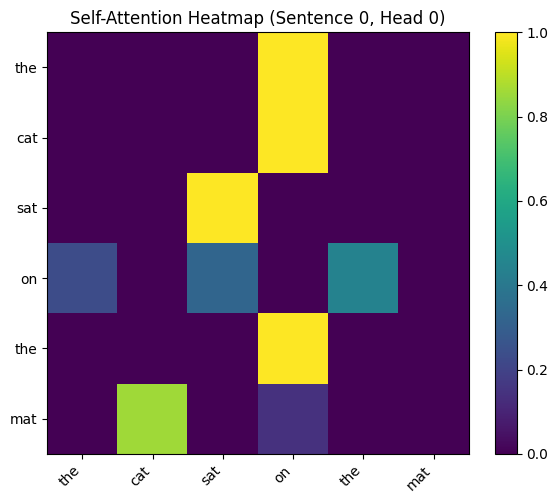

In [ ]:
#2 Question

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# =========================
# 1. Toy dataset: sentences
# =========================
sentences = [
    "the cat sat on the mat",
    "the dog sat on the rug",
    "a cat chased a mouse",
    "the dog chased the cat",
    "the bird sang a song",
    "the cat slept all day",
    "a dog barked loudly",
    "the mouse ate cheese",
    "a bird flew away",
    "the cat and dog are friends",
]

# Lowercase + whitespace tokenize
tokenized = [s.lower().split() for s in sentences]

# =========================
# 2. Build vocabulary
# =========================
PAD_TOKEN = "<PAD>"

vocab = {PAD_TOKEN}
for toks in tokenized:
    vocab.update(toks)

vocab = sorted(list(vocab))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
pad_idx = word2idx[PAD_TOKEN]
vocab_size = len(vocab)

print(f"Vocab size: {vocab_size}")
print("Vocab:", vocab)
print("-" * 60)

# Convert sentences to padded index tensors
max_len = max(len(t) for t in tokenized)

def encode_and_pad(tokens, max_len, pad_idx):
    idxs = [word2idx[w] for w in tokens]
    if len(idxs) < max_len:
        idxs = idxs + [pad_idx] * (max_len - len(idxs))
    return idxs

encoded = [encode_and_pad(t, max_len, pad_idx) for t in tokenized]
input_ids = torch.tensor(encoded, dtype=torch.long)  # (batch_size, max_len)

batch_size, seq_len = input_ids.size()
print(f"Batch size: {batch_size}, Sequence length: {seq_len}")
print("Example sentence 0:", sentences[0])
print("Tokens:", tokenized[0])
print("Token IDs:", input_ids[0].tolist())
print("-" * 60)


# =========================
# 3. Positional Encoding
# =========================
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # (d_model/2)

        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, : x.size(1)]
        return x


# =========================
# 4. Multi-Head Self-Attention
# =========================
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        """
        x: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, 1, seq_len) or None (padding mask)
        returns:
            out: (batch_size, seq_len, d_model)
            attn_weights: (batch_size, num_heads, seq_len, seq_len)
        """
        batch_size, seq_len, d_model = x.size()

        # Linear projections
        Q = self.W_q(x)  # (batch_size, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)

        # Split into heads
        # -> (batch_size, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        # (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attn_weights = F.softmax(scores, dim=-1)  # along key dimension

        # (batch_size, num_heads, seq_len, d_k)
        attn_output = torch.matmul(attn_weights, V)

        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model
        )

        # Final linear
        out = self.W_o(attn_output)  # (batch_size, seq_len, d_model)
        return out, attn_weights


# =========================
# 5. Feed-Forward + Add & Norm
# =========================
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


class EncoderLayer(nn.Module):
    def __init__(self, d_model=64, num_heads=4, d_ff=128, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ff = PositionwiseFeedForward(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        # Self-attention + Add & Norm
        attn_out, attn_weights = self.self_attn(x, src_mask)
        x = self.norm1(x + self.dropout(attn_out))

        # Feed-forward + Add & Norm
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))

        return x, attn_weights


# =========================
# 6. Full mini Encoder
# =========================
class MiniTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=64, num_heads=4, d_ff=128, max_len=100, pad_idx=0):
        super().__init__()
        self.d_model = d_model
        self.pad_idx = pad_idx

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_encoder = SinusoidalPositionalEncoding(d_model, max_len)
        self.encoder_layer = EncoderLayer(d_model, num_heads, d_ff)

    def make_pad_mask(self, src):
        """
        src: (batch_size, seq_len)
        Returns mask: (batch_size, 1, 1, seq_len)
        1 = keep, 0 = mask (ignore)
        """
        mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        # (batch_size, 1, 1, seq_len)
        return mask

    def forward(self, src):
        """
        src: (batch_size, seq_len) token IDs
        """
        src_mask = self.make_pad_mask(src)  # (batch_size, 1, 1, seq_len)

        x = self.embedding(src) * math.sqrt(self.d_model)  # (batch_size, seq_len, d_model)
        x = self.pos_encoder(x)

        contextual_embeddings, attn_weights = self.encoder_layer(x, src_mask)
        return contextual_embeddings, attn_weights


# =========================
# 7. Run the encoder
# =========================
d_model = 64
num_heads = 4
d_ff = 128
max_len = seq_len  # our toy seq_len

model = MiniTransformerEncoder(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    max_len=max_len,
    pad_idx=pad_idx,
)

with torch.no_grad():
    contextual_embeddings, attn_weights = model(input_ids)
    # contextual_embeddings: (batch_size, seq_len, d_model)
    # attn_weights: (batch_size, num_heads, seq_len, seq_len)

print("Contextual embeddings shape:", contextual_embeddings.shape)
print("-" * 60)

# Show contextual embeddings for first sentence (only non-PAD positions)
sent_idx = 0
valid_len = len(tokenized[sent_idx])
print(f"Sentence {sent_idx}:", sentences[sent_idx])
print("Tokens:", tokenized[sent_idx])
print("Final contextual embeddings for each token (truncated):")
for i in range(valid_len):
    token = tokenized[sent_idx][i]
    vec = contextual_embeddings[sent_idx, i].numpy()
    print(f"  {token:>10}: {vec[:8]} ...")  # print first 8 dims


# =========================
# 8. Attention heatmap (word-to-word)
# =========================
# Pick first sentence, first head
head_idx = 0
attn_for_sent = attn_weights[sent_idx, head_idx]  # (seq_len, seq_len)
attn_for_sent = attn_for_sent[:valid_len, :valid_len].numpy()

tokens = tokenized[sent_idx]

plt.figure(figsize=(6, 5))
plt.imshow(attn_for_sent, interpolation="nearest", aspect="equal")
plt.colorbar()
plt.xticks(range(valid_len), tokens, rotation=45, ha="right")
plt.yticks(range(valid_len), tokens)
plt.title(f"Self-Attention Heatmap (Sentence {sent_idx}, Head {head_idx})")
plt.tight_layout()
plt.show()


In [ ]:
#3 Question

import math
import torch
import torch.nn.functional as F

# For reproducibility
torch.manual_seed(0)

# ---------------------------------------------------
# 1. Implement Scaled Dot-Product Attention
#    Attention(Q,K,V) = softmax(QK^T / sqrt(d_k)) V
# ---------------------------------------------------
def scaled_dot_product_attention(Q, K, V):
    """
    Q: (batch_size, seq_len_q, d_k)
    K: (batch_size, seq_len_k, d_k)
    V: (batch_size, seq_len_k, d_v)

    Returns:
        output: (batch_size, seq_len_q, d_v)
        attn_weights: (batch_size, seq_len_q, seq_len_k)
        scaled_scores: (batch_size, seq_len_q, seq_len_k)  # logits before softmax
    """
    d_k = Q.size(-1)

    # Scores = Q K^T / sqrt(d_k)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

    # Softmax over key dimension
    attn_weights = F.softmax(scores, dim=-1)

    # Weighted sum of V
    output = torch.matmul(attn_weights, V)

    return output, attn_weights, scores


# ---------------------------------------------------
# 2. Create random Q, K, V and test
# ---------------------------------------------------
batch_size = 1
seq_len_q = 3
seq_len_k = 5
d_k = 4
d_v = 4

Q = torch.randn(batch_size, seq_len_q, d_k)
K = torch.randn(batch_size, seq_len_k, d_k)
V = torch.randn(batch_size, seq_len_k, d_v)

print("Q shape:", Q.shape)
print("K shape:", K.shape)
print("V shape:", V.shape)
print("-" * 60)

# ---------------------------------------------------
# 3. Softmax stability check: before vs after scaling
# ---------------------------------------------------
# Raw (unscaled) scores: Q K^T
raw_scores = torch.matmul(Q, K.transpose(-2, -1))  # (batch, seq_len_q, seq_len_k)
scaled_scores = raw_scores / math.sqrt(d_k)

raw_softmax = F.softmax(raw_scores, dim=-1)
scaled_softmax = F.softmax(scaled_scores, dim=-1)

print("Raw scores (QK^T) for first query position:")
print(raw_scores[0, 0])   # scores for query token 0 across all keys
print("\nScaled scores (QK^T / sqrt(d_k)) for first query position:")
print(scaled_scores[0, 0])

print("\nSoftmax over raw scores (no scaling) for first query position:")
print(raw_softmax[0, 0])

print("\nSoftmax over scaled scores (with 1/sqrt(d_k)) for first query position:")
print(scaled_softmax[0, 0])

print("\n[Stability intuition] Raw scores may be larger in magnitude -> more peaked softmax;")
print("scaling keeps logits in a moderate range -> less saturation, more stable gradients.")
print("-" * 60)

# ---------------------------------------------------
# 4. Run scaled dot-product attention
# ---------------------------------------------------
output, attn_weights, attn_logits = scaled_dot_product_attention(Q, K, V)

print("Attention weight matrix (scaled) shape:", attn_weights.shape)
print("Attention weights (batch 0):")
print(attn_weights[0])  # (seq_len_q, seq_len_k)

print("\nOutput vectors shape:", output.shape)
print("Output vectors (batch 0):")
print(output[0])  # (seq_len_q, d_v)

print("\nAttention logits used for softmax (scaled scores) for batch 0:")
print(attn_logits[0])


Q shape: torch.Size([1, 3, 4])
K shape: torch.Size([1, 5, 4])
V shape: torch.Size([1, 5, 4])
------------------------------------------------------------
Raw scores (QK^T) for first query position:
tensor([-2.2266, -1.8353, -3.4917,  3.7064, -2.2812])

Scaled scores (QK^T / sqrt(d_k)) for first query position:
tensor([-1.1133, -0.9176, -1.7458,  1.8532, -1.1406])

Softmax over raw scores (no scaling) for first query position:
tensor([2.6247e-03, 3.8817e-03, 7.4076e-04, 9.9027e-01, 2.4853e-03])

Softmax over scaled scores (with 1/sqrt(d_k)) for first query position:
tensor([0.0432, 0.0525, 0.0230, 0.8393, 0.0420])

[Stability intuition] Raw scores may be larger in magnitude -> more peaked softmax;
scaling keeps logits in a moderate range -> less saturation, more stable gradients.
------------------------------------------------------------
Attention weight matrix (scaled) shape: torch.Size([1, 3, 5])
Attention weights (batch 0):
tensor([[0.0432, 0.0525, 0.0230, 0.8393, 0.0420],
        